In [ ]:
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import Activation, Dense, Dropout, Flatten, InputLayer
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import *
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import os
import seaborn as sns
import random
import tensorflow as tf
import zipfile
import matplotlib.pyplot as plt
print("Libriaries loaded")

Libriaries loaded


In [ ]:
dataset_name = "last_dataset"
photos = zipfile.ZipFile("/content/drive/My Drive/" +  dataset_name + ".zip",'r')
photos.extractall("input/train/");
tests_photos = zipfile.ZipFile("/content/drive/My Drive/test.zip",'r')
tests_photos.extractall("input/")
if not os.path.exists("result"):
   os.mkdir("result")

In [ ]:
# Get images

inputh_shape = (128,128)
path = "/content/input/train/" + dataset_name + "/"
X = [] 
cnt = 0
for name in os.listdir(path):
    image = img_to_array(load_img(path + name))
    X.append(image)
    cnt += 1 
X = np.array(X, dtype=float)
split = int(0.95*len(X))
Xtrain = X[:split]
Xtrain = 1.0/255*Xtrain
print("Data is loaded.")
print(cnt,"img loaded.")

Data is loaded.
3328 img loaded.


In [ ]:
Xtest = rgb2lab(X[split:])[:,:,:,0]
Xtest = Xtest.reshape(Xtest.shape+(1,))
Ytest = rgb2lab(X[split:])[:,:,:,1:]
Ytest = Ytest / 128

In [ ]:
model = Sequential()
model.add(InputLayer(input_shape=(None, None, 1)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
metrics = ['mse','mae','mape', "mean_squared_logarithmic_error", "cosine_similarity", tf.keras.losses.Huber(),tf.keras.losses.LogCosh()]
model.compile(optimizer='rmsprop', loss= "mse", metrics = ["accuracy"])
print("Model is built")

Model is built


In [ ]:
history = History()

In [ ]:
def colorizeImage(img_path, shape = None, epoch = -1):
  image = img_to_array(load_img(img_path))
  if shape == None:
    shape = image.shape
    shape = (shape[0] + (8 - shape[0]%8)%8,shape[1] + (8 - shape[1]%8)%8)
  image = resize(image,shape,mode = "reflect",anti_aliasing = True)
  image = np.array(image, dtype=float)
  Xt = rgb2lab(1.0/255*image)[:,:,0]
  Xt = Xt.reshape(1, *shape, 1)
  out = model.predict(Xt)
  out *= 128
  cur = np.zeros((*shape , 3))
  print(cur.shape)
  cur[:,:,0] = Xt[0][:,:,0]
  cur[:,:,1:] = out[0]
  if not os.path.exists("/content/drive/MyDrive/finish_model/epoch_" + str(epoch)):
        os.mkdir("/content/drive/MyDrive/finish_model/epoch_" + str(epoch))
  if epoch != -1:
    imsave("/content/drive/MyDrive/finish_model/epoch_" + str(epoch) + '/' + str(epoch) + img_path.split('/')[-1], lab2rgb(cur))
  if epoch == -1:
    imsave("result/" + img_path.split('/')[-1], lab2rgb(cur))

In [ ]:
if not os.path.exists("result"):
        os.mkdir("result")
if not os.path.exists("result/models"):
        os.mkdir("result/models")
class CustomSaver(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch % 10 == 0:  # or save after some epoch, each k-th epoch etc.
            self.model.save_weights(f"/content/drive/MyDrive/finish_model/weights/model_{epoch}.h5")
            for name in os.listdir('/content/input/test/'):
                colorizeImage('/content/input/test/' + name,epoch = epoch)

In [ ]:
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)
batch_size = 100
epochs_size = 1000 
def image_a_b_gen(batch_size):
    for batch in datagen.flow(Xtrain, batch_size=batch_size):
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield (X_batch.reshape(X_batch.shape+(1,)), Y_batch)
        
saver = CustomSaver()        
model.fit_generator(image_a_b_gen(batch_size),
                    callbacks=[saver, history],
                    epochs=epochs_size,
                    steps_per_epoch= len(Xtrain) // batch_size,
                    validation_data=(Xtest,Ytest))

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/1000
31/31 [==============================] - ETA: 0s - loss: 0.9269 - accuracy: 0.6129

/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 209428 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(512, 768, 3)
(800, 1088, 3)


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 215413 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(856, 1280, 3)


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 628665 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 216913 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(528, 736, 3)
(856, 1280, 3)


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 1020754 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(1400, 1400, 3)


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 1653288 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(664, 1024, 3)


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 160514 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(776, 1024, 3)


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 503259 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(856, 1280, 3)


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 837593 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 151446 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(424, 640, 3)
(984, 1176, 3)


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 539014 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 285286 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(512, 768, 3)
(856, 1280, 3)


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 656280 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


31/31 [==============================] - 46s 1s/step - loss: 0.9269 - accuracy: 0.6129 - val_loss: 177.1274 - val_accuracy: 0.6406
Epoch 2/1000
31/31 [==============================] - 23s 748ms/step - loss: 0.9483 - accuracy: 0.6361 - val_loss: 177.1201 - val_accuracy: 0.6408
Epoch 3/1000
31/31 [==============================] - 24s 761ms/step - loss: 0.9482 - accuracy: 0.6419 - val_loss: 177.3902 - val_accuracy: 0.6363
Epoch 4/1000
31/31 [==============================] - 24s 758ms/step - loss: 0.9486 - accuracy: 0.6431 - val_loss: 177.3943 - val_accuracy: 0.6362
Epoch 5/1000
31/31 [==============================] - 23s 757ms/step - loss: 0.9495 - accuracy: 0.6401 - val_loss: 177.3943 - val_accuracy: 0.6362
Epoch 6/1000
31/31 [==============================] - 24s 770ms/step - loss: 0.7011 - accuracy: 0.5937 - val_loss: 181.9407 - val_accuracy: 0.6273
Epoch 7/1000
31/31 [==============================] - 24s 770ms/step - loss: 0.0204 - accuracy: 0.6054 - val_loss: 179.6945 - val_accu

31/31 [==============================] - 37s 1s/step - loss: 0.0027 - accuracy: 0.8305 - val_loss: 182.2307 - val_accuracy: 0.5430
Epoch 992/1000
31/31 [==============================] - 23s 741ms/step - loss: 0.0027 - accuracy: 0.8311 - val_loss: 181.9913 - val_accuracy: 0.5123
Epoch 993/1000
31/31 [==============================] - 23s 753ms/step - loss: 0.0027 - accuracy: 0.8317 - val_loss: 181.7572 - val_accuracy: 0.5663
Epoch 994/1000
31/31 [==============================] - 23s 750ms/step - loss: 0.0032 - accuracy: 0.8245 - val_loss: 180.3407 - val_accuracy: 0.5955
Epoch 995/1000
31/31 [==============================] - 23s 744ms/step - loss: 0.0026 - accuracy: 0.8349 - val_loss: 181.1897 - val_accuracy: 0.5791
Epoch 996/1000
31/31 [==============================] - 23s 749ms/step - loss: 0.0027 - accuracy: 0.8325 - val_loss: 180.6030 - val_accuracy: 0.5653
Epoch 997/1000
31/31 [==============================] - 23s 744ms/step - loss: 0.0027 - accuracy: 0.8332 - val_loss: 181.337

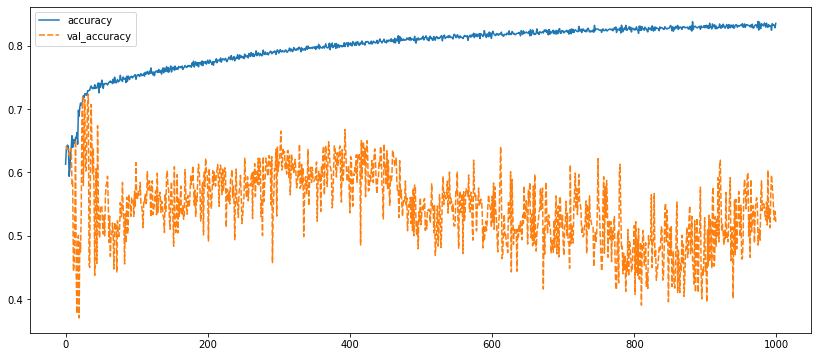

In [ ]:
plt.figure(figsize=(14,6))
sns.lineplot(data = {'accuracy':history.history['accuracy'], 'val_accuracy' : history.history['val_accuracy']})


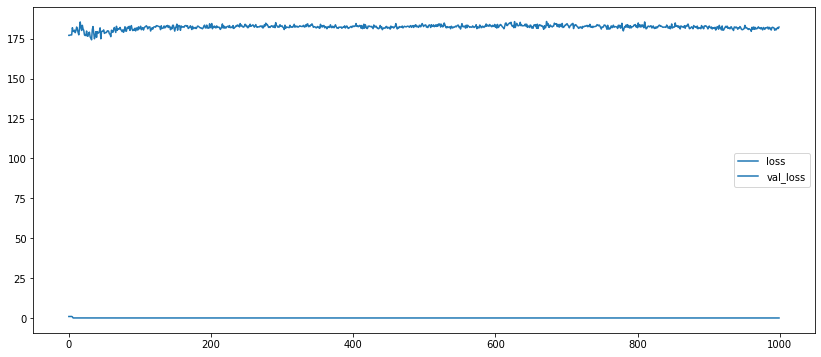

In [ ]:
plt.figure(figsize=(14,6))
sns.lineplot(data = {'loss':history.history['loss']})
sns.lineplot(data = {'val_loss' : history.history['val_loss']})

In [ ]:

testHistory = model.evaluate(Xtest, Ytest, batch_size=batch_size)
print(testHistory)

2/2 [==============================] - 1s 407ms/step - loss: 182.3492 - accuracy: 0.5216
[182.34918212890625, 0.5216119289398193]


In [ ]:
#/content/drive/MyDrive/300epch/
model_json = model.to_json()
with open("/content/model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("/content/model.h5")

In [ ]:
'''model_json = model.to_json()
with open("/content/drive/MyDrive/best_model/model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("/content/drive/MyDrive/best_model/model.h5")'''

'model_json = model.to_json()\nwith open("/content/drive/MyDrive/best_model/model.json", "w") as json_file:\n    json_file.write(model_json)\nmodel.save_weights("/content/drive/MyDrive/best_model/model.h5")'

In [ ]:
if not os.path.exists("result"):
   os.mkdir("result")
for name in os.listdir('/content/input/test/'):
    if name == "385838b7.jpg" or name == "323360-Palmy-u-dvortsa-Ordzhonikidze.jpg":
      colorizeImage('/content/input/test/' + name, shape = (512,768))
      continue
    colorizeImage('/content/input/test/' + name)

(512, 768, 3)
(800, 1088, 3)


(856, 1280, 3)


(528, 736, 3)
(856, 1280, 3)


(1400, 1400, 3)


(664, 1024, 3)


(776, 1024, 3)


(856, 1280, 3)


(424, 640, 3)
(984, 1176, 3)


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


(512, 768, 3)
(856, 1280, 3)
